In [25]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean.cm as cm

# Data Import

In [26]:
temp_logged = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/stair_collab/julie_temperature/Temp_data_high_tide_combined.csv')

In [27]:
temp_logged

,Water_level_m,Date_UTC,Mean_temp_C,Site,Lat,Lon
0,3.148,2024-03-19 15:00,8.971429,Cain_peninsula,48.879148,-123.312558
1,3.575,2024-03-19 16:00,9.100000,Cain_peninsula,48.879148,-123.312558
2,3.850,2024-03-19 17:00,9.171429,Cain_peninsula,48.879148,-123.312558
3,3.949,2024-03-19 18:00,9.371429,Cain_peninsula,48.879148,-123.312558
4,3.883,2024-03-19 19:00,9.471429,Cain_peninsula,48.879148,-123.312558
...,...,...,...,...,...,...
23314,3.464,2024-09-17 14:00,14.750000,Sharon_cove,49.339260,-123.223257
23315,3.365,2024-09-17 14:10,14.800000,Sharon_cove,49.339260,-123.223257
23316,3.272,2024-09-17 14:20,14.800000,Sharon_cove,49.339260,-123.223257
23317,3.163,2024-09-17 14:30,14.883333,Sharon_cove,49.339260,-123.223257


In [28]:
site_coords = temp_logged.set_index('Site')[['Lat', 'Lon']].drop_duplicates().to_dict('index')

In [29]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]

In [30]:
model_loc = xr.open_dataset('/ocean/cdonaldson/stair_extractions/julie/SalishSeaCast_hourly_phys_00_05_halfmoon_20240529_20240915.nc')
# 2024-05-29 09:00:00
# 2024-09-15 11:30:00

# Functions

In [31]:
def grid_from_latlon(lat_coord, lon_coord):
    lat_diff = np.abs(bathy.nav_lat - lat_coord)
    lon_diff  = np.abs(bathy.nav_lon - lon_coord)
    sum_of_diff = lat_diff + lon_diff
    intersect_idx = np.unravel_index(np.nanargmin(np.ma.masked_array(sum_of_diff, mask=tmask[5]).filled(np.nan)), sum_of_diff.shape)

    fig, ax = plt.subplots(1,2)
    cb = ax[0].pcolormesh(sum_of_diff)
    ax[0].set_ylabel('GridY')
    ax[0].set_xlabel('GridX')
    viz_tools.set_aspect(ax[0]);
    
    cb2 = ax[1].pcolormesh(np.ma.masked_array(sum_of_diff, mask=tmask[5]))
    ax[1].set_ylabel('GridY')
    ax[1].set_xlabel('GridX')
    viz_tools.set_aspect(ax[1]);
    ax[1].plot(intersect_idx[1], intersect_idx[0], 'r*')

    fig.colorbar(cb, ax=ax[:], label='Lat Diff + Lon Diff')

    print('(y, x): {}'.format(intersect_idx))
    print('Bathy: {} m'.format(bathy['Bathymetry'].isel(y=intersect_idx[0], x=intersect_idx[1]).values))

In [32]:
def plot_water_levels(site_name):
    temp_logged_site = temp_logged[temp_logged['Site'] == site_name]
    temp_logged_site['time'] = pd.to_datetime(temp_logged_site['Date_UTC'], format='%Y-%m-%d %H:%M')

    fig, ax = plt.subplots(1,1)
    ax.plot(temp_logged_site['time'], temp_logged_site['Water_level_m'], '-')
    print(temp_logged_site['time'].min())
    print(temp_logged_site['time'].max())
    print(len(temp_logged_site['time']))

    return temp_logged_site

In [33]:
def plot_temp_ts(temp_logged_site):

    fig, ax = plt.subplots(1,1)
    ax.plot(temp_logged_site['time'], temp_logged_site['Mean_temp_C'], '-')
    print(temp_logged_site['Mean_temp_C'].min())
    print(temp_logged_site['Mean_temp_C'].max())

In [34]:
def bias(obs, mod):
    return np.mean(mod - obs)

In [35]:
def rmse(obs, mod):
    return (np.sqrt(((mod - obs)**2).mean()))

# Work

## Halfmoon Bay

Halfmoon_bay
(y, x): (551, 249)
Bathy: 27.8125 m
2024-05-29 09:00:00
2024-09-15 11:30:00
1753
11.92857143
22.875
11.92857143
22.875


/tmp/ipykernel_282619/1811648375.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_logged_site['time'] = pd.to_datetime(temp_logged_site['Date_UTC'], format='%Y-%m-%d %H:%M')


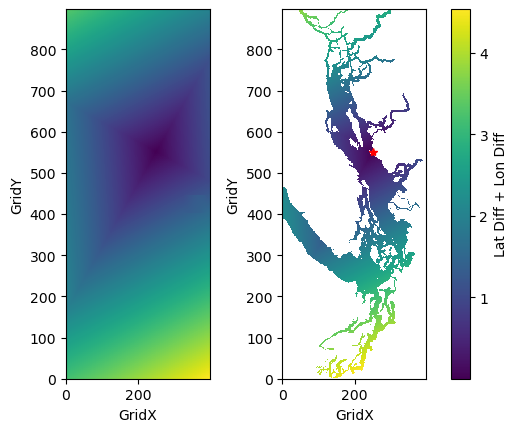

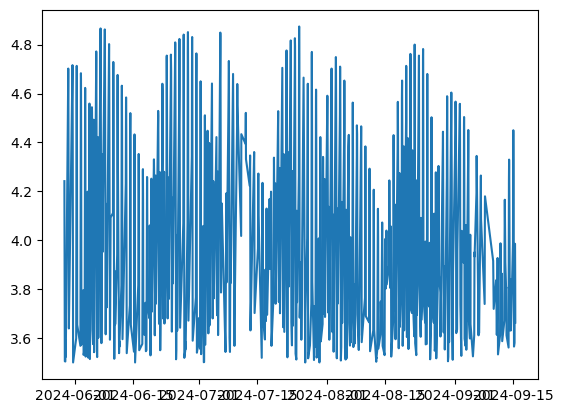

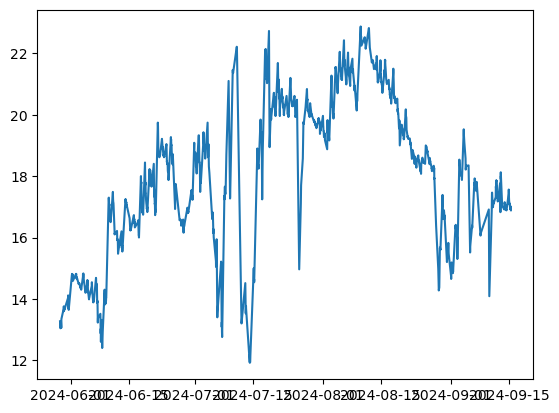

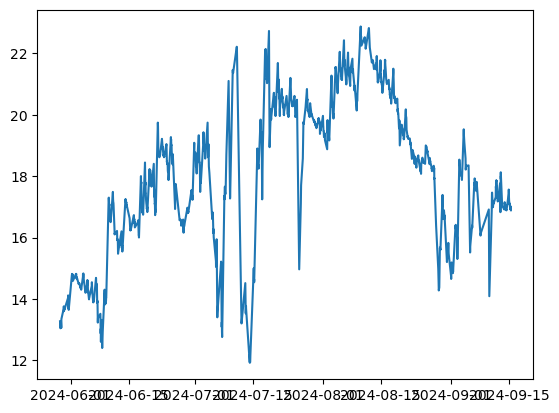

In [36]:
site_name = 'Halfmoon_bay'
lat, lon = site_coords[site_name].values()
print(site_name)
grid_from_latlon(lat, lon)
temp_logged_loc_preserve = plot_water_levels(site_name)
plot_temp_ts(temp_logged_loc_preserve)
# temp_logged_loc_preserve.loc[temp_logged_loc_preserve['Mean_temp_C'] >= 20, 'Mean_temp_C'] = np.nan
# temp_logged_loc_preserve.loc[temp_logged_loc_preserve['Mean_temp_C'].diff().abs() > 5, 'Mean_temp_C'] = np.nan
plot_temp_ts(temp_logged_loc_preserve)

In [37]:
temp_logged_loc_preserve # values every half hour; need to condense this so that it it one value per hour

,Water_level_m,Date_UTC,Mean_temp_C,Site,Lat,Lon,time
6921,4.242,2024-05-29 09:00,13.271429,Halfmoon_bay,49.508207,-123.944493,2024-05-29 09:00:00
6922,4.072,2024-05-29 09:30,13.200000,Halfmoon_bay,49.508207,-123.944493,2024-05-29 09:30:00
6923,3.902,2024-05-29 10:00,13.157143,Halfmoon_bay,49.508207,-123.944493,2024-05-29 10:00:00
6924,3.744,2024-05-29 10:30,13.128571,Halfmoon_bay,49.508207,-123.944493,2024-05-29 10:30:00
6925,3.609,2024-05-29 11:00,13.114286,Halfmoon_bay,49.508207,-123.944493,2024-05-29 11:00:00
...,...,...,...,...,...,...,...
8669,3.986,2024-09-15 09:30,16.950000,Halfmoon_bay,49.508207,-123.944493,2024-09-15 09:30:00
8670,3.986,2024-09-15 10:00,16.987500,Halfmoon_bay,49.508207,-123.944493,2024-09-15 10:00:00
8671,3.935,2024-09-15 10:30,17.012500,Halfmoon_bay,49.508207,-123.944493,2024-09-15 10:30:00
8672,3.828,2024-09-15 11:00,16.975000,Halfmoon_bay,49.508207,-123.944493,2024-09-15 11:00:00


In [38]:
temp_logged_loc = temp_logged_loc_preserve[['time', 'Water_level_m', 'Mean_temp_C']].groupby(pd.Grouper(key='time', freq='1H')).mean().reset_index()
temp_logged_loc

,time,Water_level_m,Mean_temp_C
0,2024-05-29 09:00:00,4.1570,13.235714
1,2024-05-29 10:00:00,3.8230,13.142857
2,2024-05-29 11:00:00,3.5575,13.078571
3,2024-05-29 12:00:00,NaN,NaN
4,2024-05-29 13:00:00,NaN,NaN
...,...,...,...
2614,2024-09-15 07:00:00,3.6285,16.925000
2615,2024-09-15 08:00:00,3.8215,16.937500
2616,2024-09-15 09:00:00,3.9645,16.956250
2617,2024-09-15 10:00:00,3.9605,17.000000


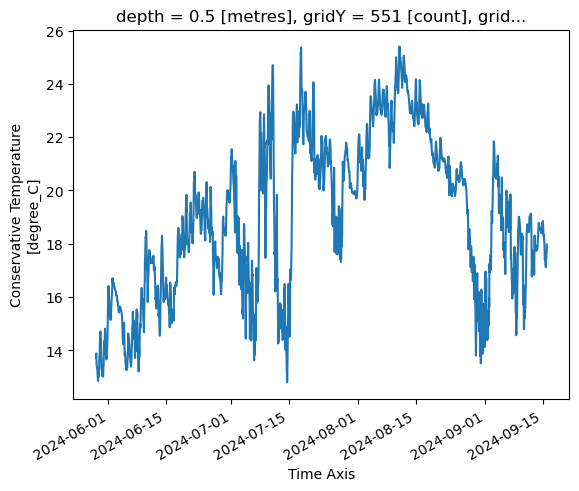

In [39]:
model_loc.votemper[:,0,0,0].plot()

In [40]:
times_loc = temp_logged_loc['time'].unique()
model_loc_filt_time = model_loc.sel(time=times_loc, method='nearest', tolerance='30min')  # because the model is at the half-hour and the logger is at the hour

In [41]:
mean_logged_lvl_loc = temp_logged_loc['Water_level_m'].mean()
print(mean_logged_lvl_loc)
model_loc_filt_time_depmean = model_loc_filt_time.sel(depth=mean_logged_lvl_loc, method='nearest')  # only includes time values that have a corresponding logger val

dep_sel = 0
model_loc_filt_time_dep_sel = model_loc_filt_time.isel(depth=dep_sel)

model_loc_depmean = model_loc.sel(depth=mean_logged_lvl_loc, method='nearest')  # includes all time values , fills in logger gaps

4.034676091269842


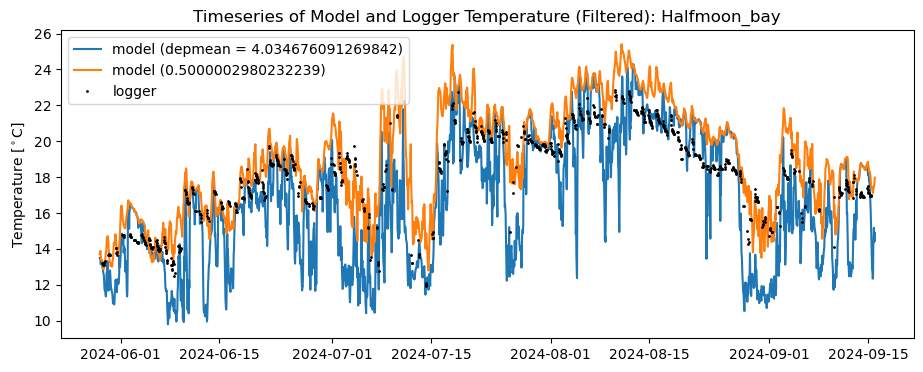

In [42]:
fig, ax = plt.subplots(1,1, figsize=(11, 4))
ax.plot(model_loc_depmean.time, model_loc_depmean.votemper[:,:,0], label='model (depmean = {})'.format(mean_logged_lvl_loc))
ax.plot(model_loc.time, model_loc.votemper[:,dep_sel,0,0], label='model ({})'.format(model_loc.depth[dep_sel].values))
# ax.plot(model_loc.time, model_loc.votemper[:,4,0,0], label='model (4.5)')
ax.plot(temp_logged_loc['time'], temp_logged_loc['Mean_temp_C'],'.', markersize=2, color='k', label='logger')
ax.set_ylabel(r'Temperature [$^\circ$C]')
ax.set_title('Timeseries of Model and Logger Temperature (Filtered): {}'.format(site_name))
ax.legend()

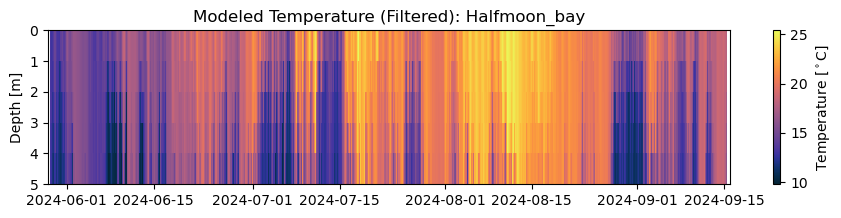

In [43]:
cmap = cm.thermal
fig, ax = plt.subplots(1,1, figsize=(11, 2))
colors = ax.pcolormesh(model_loc_filt_time.reindex_like(model_loc).time, model_loc_filt_time.reindex_like(model_loc).depth, model_loc_filt_time.reindex_like(model_loc).votemper[:,:,0,0].T, cmap=cmap)
ax.set_ylim([5,0])
ax.set_title('Modeled Temperature (Filtered): {}'.format(site_name))
ax.set_ylabel('Depth [m]')
cb = fig.colorbar(colors, ax=ax, label=r'Temperature [$^\circ$C]', orientation='vertical')

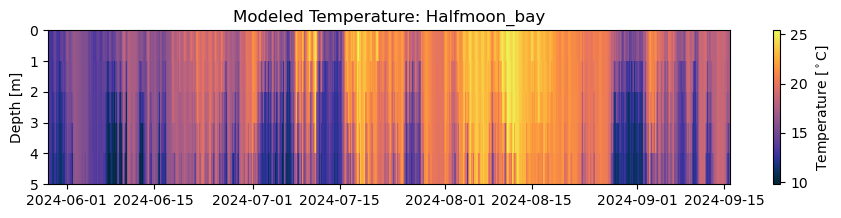

In [44]:
cmap = cm.thermal
fig, ax = plt.subplots(1,1, figsize=(11, 2))
colors = ax.pcolormesh(model_loc.time, model_loc.depth, model_loc.votemper[:,:,0,0].T, cmap=cmap)
ax.set_ylim([5,0])
ax.set_title('Modeled Temperature: {}'.format(site_name))
ax.set_ylabel('Depth [m]')
cb = fig.colorbar(colors, ax=ax, label=r'Temperature [$^\circ$C]', orientation='vertical')

### Dep Mean

In [45]:
#  obs, mod
diff_loc = model_loc_filt_time_depmean.votemper[:,0,0].values - temp_logged_loc['Mean_temp_C']
bias_loc = bias(temp_logged_loc['Mean_temp_C'], model_loc_filt_time_depmean.votemper[:,0,0].values)
rmse_loc = rmse(temp_logged_loc['Mean_temp_C'], model_loc_filt_time_depmean.votemper[:,0,0].values)

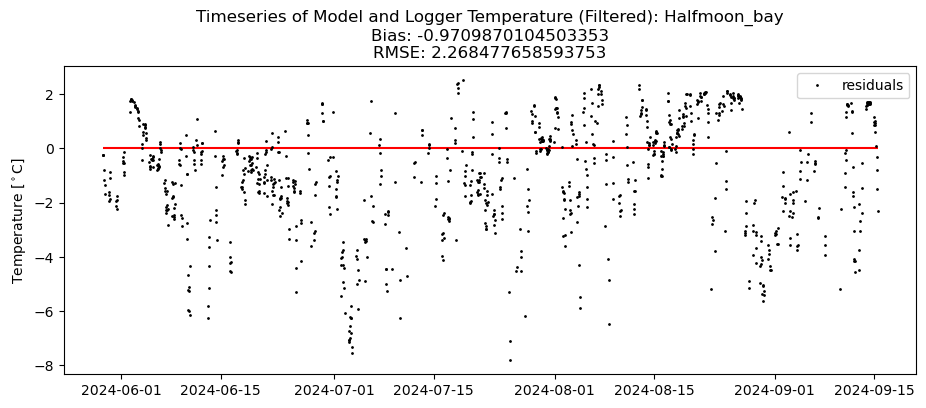

In [46]:
fig, ax = plt.subplots(1,1, figsize=(11, 4))
ax.plot(temp_logged_loc['time'], diff_loc,'.', markersize=2, color='k', label='residuals')
ax.hlines(0, temp_logged_loc['time'].min(), temp_logged_loc['time'].max(), color='r', zorder=0)
ax.set_ylabel(r'Temperature [$^\circ$C]')
ax.set_title('Timeseries of Model and Logger Temperature (Filtered): {}\nBias: {}\nRMSE: {}'.format(site_name, bias_loc, rmse_loc))
ax.legend()

### Dep Sel

In [47]:
#  obs, mod
diff_loc_sel = model_loc_filt_time_dep_sel.votemper[:,0,0].values - temp_logged_loc['Mean_temp_C']
bias_loc_sel = bias(temp_logged_loc['Mean_temp_C'], model_loc_filt_time_dep_sel.votemper[:,0,0].values)
rmse_loc_sel = rmse(temp_logged_loc['Mean_temp_C'], model_loc_filt_time_dep_sel.votemper[:,0,0].values)

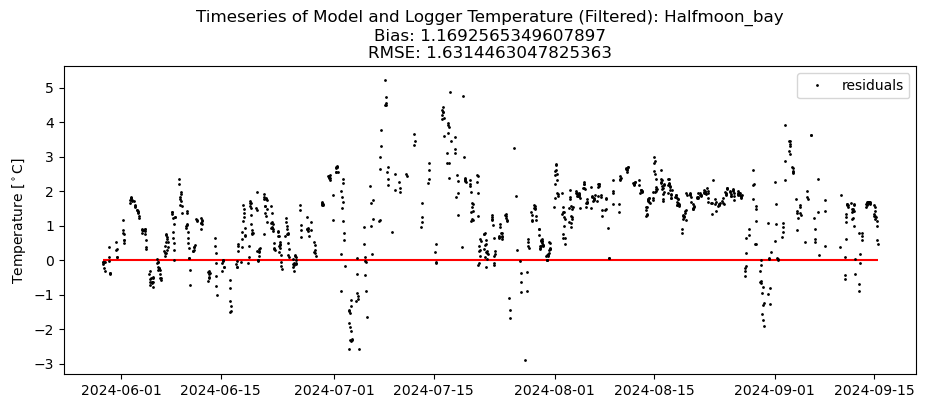

In [48]:
fig, ax = plt.subplots(1,1, figsize=(11, 4))
ax.plot(temp_logged_loc['time'], diff_loc_sel,'.', markersize=2, color='k', label='residuals')
ax.hlines(0, temp_logged_loc['time'].min(), temp_logged_loc['time'].max(), color='r', zorder=0)
ax.set_ylabel(r'Temperature [$^\circ$C]')
ax.set_title('Timeseries of Model and Logger Temperature (Filtered): {}\nBias: {}\nRMSE: {}'.format(site_name, bias_loc_sel, rmse_loc_sel))
ax.legend()